## First look at UGC993

Finding emission lines and calculating redshift

In [49]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import specutils
import astropy.units as u

from astropy.io import fits

from specutils import Spectrum1D, SpectralRegion
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
from astropy.nddata import StdDevUncertainty
from specutils.fitting import find_lines_threshold
from specutils.fitting import fit_continuum

from astropy.modeling import models, fitting

mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'

In [3]:
ugc993 = fits.open('UGC993.fits')

In [5]:
header = ugc993[1].header

In [6]:
wavelength = np.arange(header['CRVAL3'], header['CRVAL3'] + header['CD3_3'] * header['NAXIS3'], header['CD3_3'])

fluxCube = ugc993[1].data
errorCube = ugc993[2].data

In [55]:
whiteImage = np.nansum(fluxCube, axis=0)

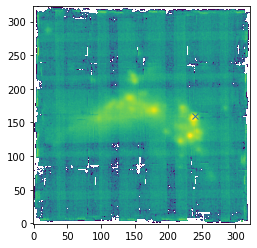

In [56]:
plt.imshow(whiteImage, origin='lower', norm=mpl.colors.LogNorm(vmin=100, vmax=1e5));

plt.plot(240, 160, 'x')

# plt.ylim(100, 200)
# plt.xlim(100, 200);

In [ ]:
plt.plot(wavelength, fluxCube[:, 160, 240], 'k-');
#plt.xlim(6521.03515625, 6533.53515625)
plt.title('Noise over 10 pixels')


#print(np.mean(fluxCube[1417:1427, 160, 240]))


#### From SDSS:

H Beta - 4862.68

O III - 4960.295

O III - 5008.240

H alpha - 6564.61

In [7]:
#Wavelengths = [H beta, O III, O III, H alpha]
labs = np.array([4862.68, 4960.295, 5008.240, 6564.61])


In [8]:
def redshift(lab, observed):
    '''
    Function to calculate redshift
    '''
    return (observed - lab)/lab

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)

fig.suptitle('Zoomed emission lines')

fig.text(0.35, 0.01, 'Wavelength (Angstroms)')
fig.text(0.01, 0.15, 'Flux (10^(-20)*erg/s/cm^2/Angstrom)', rotation='vertical')

ax1.plot(wavelength, fluxCube[:, 160, 240])
ax1.set_xlim(4750, 5100)
ax2.plot(wavelength, fluxCube[:, 160, 240])
ax2.set_xlim(6600, 6700)

# Specutils

Need to redefine the spectra in terms of specutils/astropy quantities

In [9]:
lamb = wavelength * u.AA 
flux = fluxCube[:, 160, 240]* 10**-20 * u.Unit('erg cm-2 s-1 AA-1')

spec = Spectrum1D(spectral_axis = lamb, flux=flux, 
                  uncertainty = StdDevUncertainty(np.sqrt(errorCube[:, 160, 240])* 10**-20))

print(spec.shape)

(3801,)


In [ ]:
f, ax = plt.subplots()  

ax.step(spec.spectral_axis, spec.flux) 

ax.set_xlim(6000, 7000)

# Searching for lines with specutils

In [10]:
lines = find_lines_threshold(spec, noise_factor= 20)  
#lines = find_lines_threshold(spec, flux_threshold=0.25)

#lines[lines['line_type'] == 'emission']  

lines

line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
4909.02001953125,emission,247
5007.77001953125,emission,326
5055.27001953125,emission,364
6627.77001953125,emission,1622


In [ ]:
spec_obs = lines['line_center']#[0]

spec_redshift = redshift(labs*u.AA, spec_obs)

print(spec_redshift)
print(f'Mean calculated redshift: {np.mean(spec_redshift)}')


In [ ]:
print(wavelength[1622])

###### Find and subtract noise 

no lines between 10 angstrom range:

indices 1400, 1470

wavelength 6350 6440


In [11]:
halphaNoise = (fluxCube[1605:1615])


In [ ]:
halphaImage = np.nansum(fluxCube[1617:1627], axis=0)
print(halphaImage.shape)

plt.imshow(halphaImage, origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e5));
plt.title('No noise removed')
plt.contourf(halphaImage, levels=[50, 75, 150, 250])



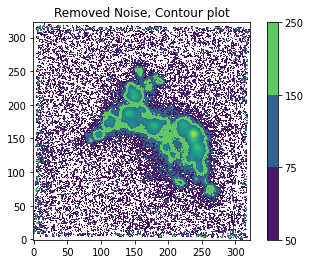

In [12]:
#Removing background noise from spectrum

HalphaImage = np.nansum((fluxCube[1617:1627] - halphaNoise), axis=0)

plt.title('Removed Noise, Contour plot')
plt.imshow(HalphaImage, origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e5));

plt.contourf(HalphaImage, levels=[50, 75, 150, 250])
plt.colorbar()

#### Masked cubes

In [13]:
#Flux250 = fluxCube[:, np.array(np.where(HalphaImage >= 250))[0], np.array(np.where(HalphaImage >= 250))[1]]
Flux75 = fluxCube[:, np.array(np.where(HalphaImage >= 75))[0], np.array(np.where(HalphaImage >= 75))[1]]
#Flux10 = fluxCube[:, np.array(np.where(HalphaImage >= 10))[0], np.array(np.where(HalphaImage >= 10))[1]]

In [ ]:
#230, 150
np.array(np.where(HalphaImage >= 75)).shape

In [ ]:
x = (np.where((np.where(HalphaImage>=75))[1]==150))
y = (np.where((np.where(HalphaImage >= 75))[0]==230))

print(x)
print(y)

In [ ]:
print((np.where(HalphaImage >= 75))[1][12842])
print((np.where(HalphaImage >= 75))[0][12842])

In [ ]:
#print(Flux250.shape)
print(Flux75.shape)
#print(Flux10.shape)

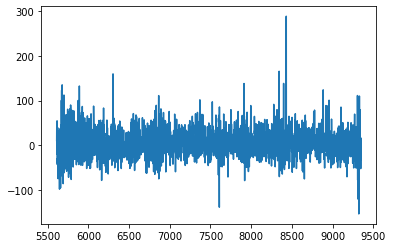

In [91]:
#plt.plot(wavelength, fluxCube[:, (np.where(HalphaImage >= 100))[0][7134], (np.where(HalphaImage >= 100))[1][7134]])
#[ 7827  8568  3033  8853 13556    45    25 13730   542    64]
plt.plot(wavelength, Flux75[:, 64])

In [14]:
#Error250 = errorCube[:, np.array(np.where(HalphaImage >= 250))[0], np.array(np.where(HalphaImage >= 250))[1]]
Error75 = errorCube[:, np.array(np.where(HalphaImage >= 75))[0], np.array(np.where(HalphaImage >=75))[1]]
#Error10 = errorCube[:, np.array(np.where(HalphaImage >= 10))[0], np.array(np.where(HalphaImage >= 10))[1]]

Can now start trying to fit for the masked values

## Question

am I fitting gaussian to the 10 pixel length?

In [ ]:
plt.plot(wavelength[1600:1700], fluxCube[1600:1700, 230, 150] - np.mean(halphaNoise[:, 230, 150]), label='noise subtracted')
#plt.plot(wavelength[1600:1700], fluxCube[1600:1700, 230, 150], label='raw data')
#plt.xlim(6500.78515625, 6600.03515625)
#plt.ylim(-500, 500)
plt.legend()
plt.title('H-alpha line, 10 pixels')


Try fitting individual line 

In [ ]:
print(wavelength[1600])
print(wavelength[1680])

In [ ]:
from astropy.modeling import models, fitting
from specutils.fitting import fit_continuum

if str(np.float64(fluxCube[1625:1650, 230, 150].max())) == 'nan':
    centre_pixel = np.array([1631]),
    print('NAN')
else:
    centre_pixel = (np.where(fluxCube[:, 230, 150] == fluxCube[1625:1650, 230, 150].max()))

#print(centre_pixel)
centre = int(np.float64(centre_pixel[-1]))

redshift_estimate = redshift(labs[-1], wavelength[int(np.float64(centre_pixel[-1]))])
#print(f'redshift estimate: {redshift_estimate}')
#print(f'integer value of max peak: {centre}')


# Model H alpha line using Gaussian 1D
#=======================================================================
#should spectrum be only 10 pixel range? Probably not, need to model continuum too. Say 50 each side
spectrum = Spectrum1D(flux = fluxCube[centre-50:centre+50, 230, 150]*u.Unit('erg cm-2 s-1 AA-1'),
            spectral_axis=wavelength[centre-50:centre+50]*u.AA)

#print(f'spectrum: {spectrum}')
sub_region = SpectralRegion(6620*u.AA, 6635*u.AA)

sub_spectrum = extract_region(spectrum, sub_region)
#print(f'sub spectrum: {sub_spectrum}')


c_init = fit_continuum(spectrum, model = models.Polynomial1D(1, c0=6.51286088, c1=0),
                       window=[(6560*u.AA, 6620*u.AA), (6650*u.AA, 6700*u.AA)])
c_model = c_init(wavelength[centre-50:centre+50]*u.AA)

print(np.float64(c_init.c1))

sub_spectrum = extract_region(spectrum - c_model, sub_region)

estimate = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))
    

print(f'estimate: {estimate}')

if str(np.float64(estimate.stddev)) == 'nan':
    print('NAN')
    g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                       mean=np.float64(estimate.mean), stddev=1*u.AA)
else:
    print(f'standard deviation: {np.float64(estimate.stddev)}')
    g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                       mean=np.float64(estimate.mean), stddev=np.float64(estimate.stddev))


g_fit = fit_lines(spectrum, g_init,
                  window=[(6620*u.AA, 6640*u.AA)])
y_fit = g_fit(wavelength*u.AA)
print(f'Model amplitude: {np.float64(g_fit.amplitude)}')
print(f'Model mean: {np.float64(g_fit.mean)}')

plt.plot(wavelength, fluxCube[:, 230, 150], label="Original spectrum")
plt.plot(wavelength, y_fit, label="Fit result")
plt.title('Single fit peak')
plt.xlim(6600, 6725)
plt.grid(True)

plt.ylim(-100, 200)
plt.legend()


In [ ]:
sub_region = SpectralRegion(6600*u.AA, 6700*u.AA)

sub_spectrum = extract_region(spectrum, sub_region)

#print(estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

estimates = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

print(np.float64(estimates.amplitude))

print(estimates.amplitude)
print(estimates.mean)
print(estimates.stddev)



## Function

Use contour lines H alpha to get pixels that will be used in an array

input array wavelength, flux

In function:

Plot spectrum

Find lines

Calculate redshift

Fit lines

Plot fitted with spectrum, save values


In [15]:
def function(wavelength, fluxMask, error):
    '''
    Function to fit H alpha lines
    :param wavelength: array of shape (3801,) of wavelengths over spectrum, units Angstrom
    :param fluxMask: fluxes for spaxels where Flux > value
    :param error: error on fluxes for masked spaxels
    :return amplitude: amplitude of Gaussian for fitted H alpha emission line
    :param mean: centre wavelength of peak 
    :param stddev: standard deviation, or width of line
    :param redshift_value: calculated redshift using param mean and lab observed H alpha wavelength 
    '''
    #print(f'number of pixels: {len(fluxMask)}')
    #length = len(fluxMask)
    # Write spectrum astropy way and plot spectrum
    #=======================================================================
    specutils.conf.do_continuum_function_check = False
    
    lamb = wavelength * u.AA 
    fluxData = fluxMask * u.Unit('erg cm^-2 s^-1 AA^-1')
    spec = Spectrum1D(spectral_axis = lamb, flux=fluxData, 
                  uncertainty = StdDevUncertainty(np.sqrt(error)* 10**-20))
    
    #f, ax = plt.subplots()  

    #ax.step(spec.spectral_axis, (spec.flux))
    #ax.set_xlim(6500, 6700)
    
    # Find lines and calculate redshift
    #========================================================================
    #lines = find_lines_threshold(spec, noise_factor = 50)  
    
    #spec_obs = lines['line_center'][lines['line_type'] == 'emission']
    
    #if len(spec_obs)==4:
        #spec_redshift = redshift(labs*u.AA, spec_obs)
        #print(f'Mean calculated redshift: {np.mean(spec_redshift)}')
        
    #if len(spec_obs) == 0:
        #print(f'No lines found')
        
    #else:
        #print(f'{len(spec_obs)} lines found')
        #print(spec_obs)
        
    #print(f'flux shape: {fluxData.shape}')
    
    # Find centre pixel of H alpha line
    #=======================================================================
    if str(np.float64(fluxData[1625:1650].max())) == 'nan':
        centre_pixel = np.array([1631]),
        print('NAN')
    else:
        centre_pixel = (np.where(fluxData == fluxData[1625:1650].max()))
    
    #print(centre_pixel)
    centre = int(np.float64(centre_pixel[-1]))
    
    #redshift_estimate = redshift(labs[-1], wavelength[int(np.float64(centre_pixel[-1]))])
    #print(f'redshift estimate: {redshift_estimate}')
    #print(f'integer value of max peak: {centre}')
    
    
    # Model H alpha line using Gaussian 1D
    #=======================================================================
    #should spectrum be only 10 pixel range? Probably not, need to model continuum too. Say 50 each side
    spectrum = Spectrum1D(flux =
                fluxData[centre-50:centre+50],
                spectral_axis=wavelength[centre-50:centre+50]*u.AA)

    #print(f'spectrum: {spectrum}')
    sub_region = SpectralRegion(6620*u.AA, 6635*u.AA)

    sub_spectrum = extract_region(spectrum, sub_region)
    #print(f'sub spectrum: {sub_spectrum}')
       
    c_init = fit_continuum(spectrum, model = models.Polynomial1D(1, c0=6.51286088, c1=0),
                           window=[(6560*u.AA, 6620*u.AA), (6650*u.AA, 6700*u.AA)])
    
    c_model = c_init(wavelength[centre-50:centre+50]*u.AA)
    
    sub_spectrum = extract_region(spectrum - c_model, sub_region)
    
    estimate = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))
    #print(f'estimate: {str(np.float64(estimate.stddev))}')
    #print(f'estimate: {(np.float64(estimate.amplitude))}')
    #print(f'estimate: {estimate}')
    
    
    #if (np.float64(estimate.amplitude)) <= 0:
        #print(f'no amplitude found')
        #g_init = models.Gaussian1D(amplitude = 20*u.Unit('erg cm^-2 s^-1 AA^-1'),
        #                          mean=np.float64(estimate.mean), stddev=1*u.AA)
        
    if str(np.float64(estimate.stddev)) == 'nan':
        #print('NAN')
        g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                           mean=np.float64(estimate.mean), stddev=1*u.AA)
    else:
        #print(f'standard deviation: {np.float64(estimate.stddev)}')
        g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                           mean=np.float64(estimate.mean), stddev=np.float64(estimate.stddev))
            
    g_fit = fit_lines(spectrum, g_init,
                      window=[(6620*u.AA, 6630*u.AA)])
    y_fit = g_fit(wavelength*u.AA)
    
    #print(f'Model amplitude: {np.float64(g_fit.amplitude)}')
    #print(f'Model mean: {np.float64(g_fit.mean)}')
    
    redshift_value = redshift(labs[-1], np.float64(g_fit.mean))
    #print(f'redshift value: {redshift_value}')
    
    # Plot the original spectrum and the fitted.
    #=======================================================================
    
    #plt.plot(wavelength, fluxData, label="Original spectrum")
    #plt.plot(wavelength, y_fit, label="Fit result")
    #plt.title('Single fit peak')
    #plt.xlim(6500, 6650)
    #plt.ylim(0, 300)
    #plt.grid(True)
    #plt.legend()
    
    # Save Parameters
    #=============================================================================
    amplitude = np.float64(g_fit.amplitude)
    mean = np.float64(g_fit.mean)
    stddev = np.float64(g_fit.stddev)
    c_0 = np.float64(c_init.c0)
    c_1 = np.float64(c_init.c1)
    
    return c_0, c_1, amplitude, mean, stddev, redshift_value

    
    
    
    

In [16]:
def velocity_calc(lambda_):
    '''
    Function to calculate velocity, using peak wavelength
    '''
    return 3e5 * (lambda_ - 6563)/6563

def sigma_calc(std_dev):
    '''
    Function to calculate sigma, with instrument error removed
    sigma_obs^2 = sigma_real^2 + sigma_instrument^2
    '''
    #check whether instrument sigma^2 = 1
    return 3e5 * (np.sqrt(std_dev**2-1**2)/6563) 

In [17]:
def model(lambda_, c0, c1, A, mu, sigma):
    '''
    Function to plot model of emission line, continuum and gaussian
    So we can check residuals of the brightest spaxels
    :param lambda_: wavelength
    :param c0: y-intercept of continuum
    :param c1: gradient of continuum
    :param A: amplitude of gaussian
    :param mu: mean of gaussian
    :param sigma: standard deviation of gaussian
    :returns y: y = c0 + c1*x + Aexp(-(x-mu)^2/(2*sigma^2))
    '''
    y = c0 + c1*lambda_ + A*np.exp(-(lambda_ - mu)**2/(2*sigma**2))
    return y

In [ ]:
print(wavelength.shape)
#3155 3365
plt.plot(wavelength, Flux250[:, 3155+18])
#plt.axvline(6623, 0, 1, linestyle = 'dotted')
#plt.axvline(6635, 0, 1, linestyle = 'dotted')
#plt.axhline(14.8, 0, 1, linestyle = 'dotted')
plt.xlim(6500, 6700)
#plt.ylim(0, 150)

function(wavelength, (Flux250[:, 3155+18]), (Error250[:, 3155+18]))

In [ ]:
print(len(Flux250))

# Flux > 250

In [ ]:
import warnings

warnings.filterwarnings("ignore", message="[astropy.modeling.fitting]")

amplitudes_list = np.zeros(5058-18)
mean_list = np.zeros(5058-18)
stddev_list = np.zeros(5058-18)
red_list = np.zeros(5058-18)

# Try running loop of 10 pixels
for i in range(18, 5058):
    amplitudes_list[i-18], mean_list[i-18], stddev_list[i-18], red_list[i-18] = function(wavelength, (Flux250[:, i]), (Error250[:, i]))
    
    
    
    

In [ ]:
amp_array = np.zeros((HalphaImage).shape)
red_array = np.zeros((HalphaImage).shape)
std_array = np.zeros((HalphaImage).shape)
mean_array = np.zeros((HalphaImage).shape)

for i in range(5040):
    amp_array[(np.where(HalphaImage>=250))[0][i+18], (np.where(HalphaImage>=250))[1][i+18]] = amplitudes_list[i]
    red_array[(np.where(HalphaImage>=250))[0][i+18], (np.where(HalphaImage>=250))[1][i+18]] = red_list[i]
    std_array[(np.where(HalphaImage>=250))[0][i+18], (np.where(HalphaImage>=250))[1][i+18]] = stddev_list[i]
    mean_array[(np.where(HalphaImage>=250))[0][i+18], (np.where(HalphaImage>=250))[1][i+18]] = mean_list[i]
    



In [ ]:
print(len(np.where(HalphaImage>=75)[0]))

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(2, 2, figsize = (10, 10))
fig.suptitle('For Flux > 250, around 5000 pixels', fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.2)

#-------------------------------------------------------------------------------------------
im1 = axs[0, 0].imshow(amp_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e3))
axs[0, 0].set_title('Amplitudes')

divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label='10^(-20)*erg/s/cm^2/Angstrom')

#-------------------------------------------------------------------------------------------
im2 = axs[0, 1].imshow(red_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=0.0090, vmax=0.01))
axs[0, 1].set_title('Redshift')

divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

#-------------------------------------------------------------------------------------------
im3 = axs[1, 0].imshow(std_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=1, vmax=1.5))
axs[1, 0].set_title('Standard Deviation')

divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label='Angstrom');

#-------------------------------------------------------------------------------------------
im4 = axs[1, 1].imshow(mean_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=6623, vmax=6628))
axs[1, 1].set_title('Peak Wavelength')

divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label='Angstrom');

why is it upside down?

In [ ]:
velocities = velocity_calc(mean_array)

In [ ]:
print(np.nanmedian(velocities[velocities>0]))
print(velocities.min())

In [ ]:
plt.imshow(velocities,  origin='lower', norm=mpl.colors.Normalize(vmin=2800, vmax=3000))

In [ ]:
sigmas = sigma_calc(std_array) #correct for instrument

In [ ]:
print(np.nanmedian(sigmas[sigmas>0]))
print(sigmas.min())

In [ ]:
plt.imshow(sigmas,  origin='lower', norm=mpl.colors.Normalize(vmin=10, vmax=60))
plt.colorbar()

In [ ]:
print(amplitudes_list.shape)
#Don't want to include high redshifts, too high std devs, any where the mean is zero in averages

print(np.where(red_list>=0.012))
print(np.where(stddev_list >= 5))
print(np.where(mean_list <= 6620))

In [ ]:
print('DISCARDING BAD FITS')
print(f'mean peak wavelength: {np.mean(mean_list[np.r_[0:51, 53:3154, 3156:3364, 3366:4881, 4883:4903, 4906:5009]])} Angstrom')

print(f'mean redshift: {np.mean(red_list[np.r_[0:51, 53:3154, 3156:3364, 3366:4881, 4883:4903, 4906:5009]])}')

print(f'mean std dev: {np.mean(stddev_list[np.r_[0:51, 53:3154, 3156:3364, 3366:4881, 4883:4903, 4906:5009]])} Angstrom')

In [ ]:
# Keep track of brightest pixels:

#(np.where(amplitudes_list >= 700))
idx = (-amplitudes_list).argsort()[:10]
print(f'10 brightest pixels: {idx}')

print(amplitudes_list[1844])


In [ ]:
fig, axs = plt.subplots(5, 2, figsize = (10, 15))

axs[0, 0].plot(wavelength, Flux250[:, idx[0]+18])
axs[0, 1].plot(wavelength, Flux250[:, idx[1]+18])
axs[1, 0].plot(wavelength, Flux250[:, idx[2]+18])
axs[1, 1].plot(wavelength, Flux250[:, idx[3]+18])
axs[2, 0].plot(wavelength, Flux250[:, idx[4]+18])
axs[2, 1].plot(wavelength, Flux250[:, idx[5]+18])
axs[3, 0].plot(wavelength, Flux250[:, idx[6]+18])
axs[3, 1].plot(wavelength, Flux250[:, idx[7]+18])
axs[4, 0].plot(wavelength, Flux250[:, idx[8]+18])
axs[4, 1].plot(wavelength, Flux250[:, idx[9]+18])

# Results

In [ ]:
print(amplitudes_list[np.where(stddev_list>=3)], mean_list[np.where(stddev_list>=3)], stddev_list[np.where(stddev_list>=3)], red_list[np.where(stddev_list>=3)])
print(np.mean(red_list))
print(np.mean(stddev_list))
#print(np.mean(amplitudes_list))
print(np.mean(mean_list))

# Flux > 75, 13788 spaxels

In [19]:
import warnings

warnings.filterwarnings("ignore", message="[astropy.modeling.fitting]")


amplitudes75 = np.zeros(13788)
mean75 = np.zeros(len(amplitudes75))
stddev75 = np.zeros(len(amplitudes75))
red75 = np.zeros(len(amplitudes75))
c0_75 = np.zeros(len(amplitudes75))
c1_75 = np.zeros(len(amplitudes75))

#all spaxels
for i in range(0, 5000):
    c0_75[i], c1_75[i], amplitudes75[i], mean75[i], stddev75[i], red75[i] = function(wavelength, (Flux75[:, i]), (Error75[:, i]))
    

    
    
    

NAN
NAN
NAN
NAN
NAN
NAN


In [21]:
#having to split up running function as Jupyter runs out of memory and kernel fails 
#if I do all at once
#so max 5000 for now

for i in range(5000, 10000):
    c0_75[i], c1_75[i], amplitudes75[i], mean75[i], stddev75[i], red75[i] = function(wavelength, Flux75[:, i], Error75[:, i])
    


NAN
NAN


In [22]:
for i in range(10000, len(amplitudes75)):
    c0_75[i], c1_75[i], amplitudes75[i], mean75[i], stddev75[i], red75[i] = function(wavelength, Flux75[:, i], Error75[:, i])
    


NAN
NAN
NAN
NAN


In [ ]:
print(function(wavelength, (Flux75[:, 12842]), (Error75[:, 12842])))

In [24]:
amp75_array = np.zeros((HalphaImage).shape)
red75_array = np.zeros((HalphaImage).shape)
std75_array = np.zeros((HalphaImage).shape)
mean75_array = np.zeros((HalphaImage).shape)

for i in range(13788):
    amp75_array[(np.where(HalphaImage>=75))[0][i], (np.where(HalphaImage>=75))[1][i]] = amplitudes75[i]
    red75_array[(np.where(HalphaImage>=75))[0][i], (np.where(HalphaImage>=75))[1][i]] = red75[i]
    std75_array[(np.where(HalphaImage>=75))[0][i], (np.where(HalphaImage>=75))[1][i]] = stddev75[i]
    mean75_array[(np.where(HalphaImage>=75))[0][i], (np.where(HalphaImage>=75))[1][i]] = mean75[i]
    


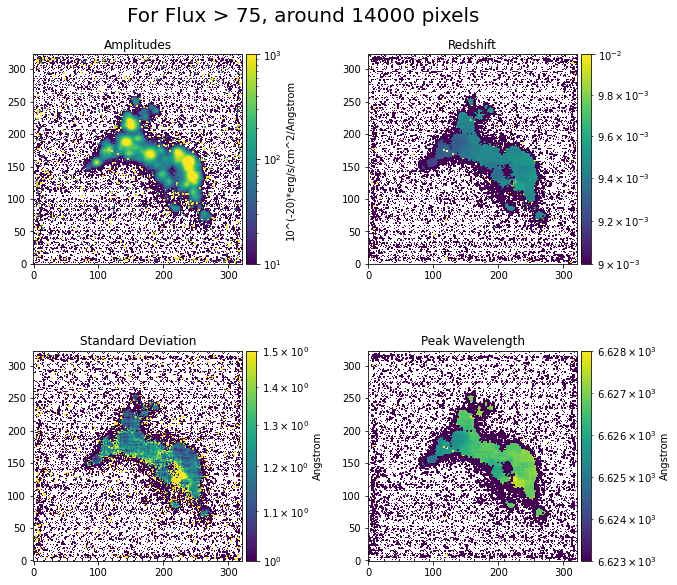

In [175]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(2, 2, figsize = (10, 10))
fig.suptitle('For Flux > 75, around 14000 pixels', y = 0.92, fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.2)

#-------------------------------------------------------------------------------------------
im1 = axs[0, 0].imshow(amp75_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e3))
axs[0, 0].set_title('Amplitudes')

divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label='10^(-20)*erg/s/cm^2/Angstrom')

#-------------------------------------------------------------------------------------------
im2 = axs[0, 1].imshow(red75_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=0.0090, vmax=0.01))
axs[0, 1].set_title('Redshift')

divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

#-------------------------------------------------------------------------------------------
im3 = axs[1, 0].imshow(std75_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=1, vmax=1.5))
axs[1, 0].set_title('Standard Deviation')

divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label='Angstrom');

#-------------------------------------------------------------------------------------------
im4 = axs[1, 1].imshow(mean75_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=6623, vmax=6628))
axs[1, 1].set_title('Peak Wavelength')

divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label='Angstrom');

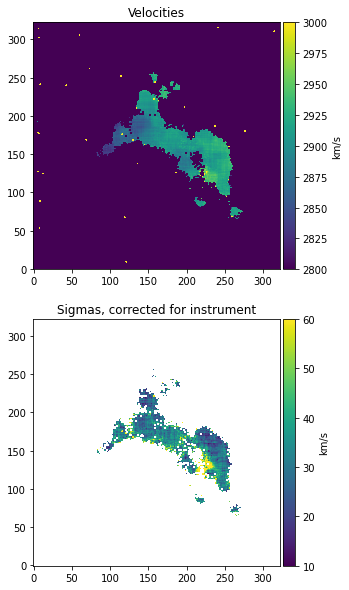

In [61]:
velocities = velocity_calc(mean75_array)

sigmas = sigma_calc(std75_array) #correct for instrument

fig, axs = plt.subplots(2, figsize = (10, 10))

im1 = axs[0].imshow(velocities,  origin='lower', norm=mpl.colors.Normalize(vmin=2800, vmax=3000))
axs[0].set_title('Velocities')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = 'km/s');

im2 = axs[1].imshow(sigmas,  origin='lower', norm=mpl.colors.Normalize(vmin=10, vmax=60))
axs[1].set_title('Sigmas, corrected for instrument')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label='km/s');



In [132]:

#Don't want to include high redshifts, too high std devs, any where the mean is zero in averages

#print(np.where(red75 >=0.012))

#print(np.where(stddev75 >= 5))

#print(np.where(mean75 <= 6620))

print('DISCARDING BAD FITS')

new_red = np.delete(red75, np.where(stddev75 >= 5)) 
new_stddev = np.delete(stddev75, np.where(stddev75 >= 5))
new_mean = np.delete(mean75, np.where(stddev75 >= 5))
new_amplitude = np.delete(amplitudes75, np.where(stddev75 >= 5))
print(new_mean.shape)

new_stddev = np.delete(new_stddev, np.where(new_red >= 0.012))
new_mean = np.delete(new_mean, np.where(new_red >= 0.012))
new_amplitude = np.delete(new_amplitude, np.where(new_red >= 0.012))
new_red = np.delete(new_red, np.where(new_red >= 0.012))
print(new_mean.shape)

new_red = np.delete(new_red, np.where(new_mean <= 6620))
new_stddev = np.delete(new_stddev, np.where(new_mean <= 6620))
new_amplitude = np.delete(new_amplitude, np.where(new_mean <= 6620))
new_mean = np.delete(new_mean, np.where(new_mean <= 6620))
print(new_mean.shape)

new_red = np.delete(new_red, np.where(new_mean >= 6630.9))
new_stddev = np.delete(new_stddev, np.where(new_mean >= 6630.9))
new_amplitude = np.delete(new_amplitude, np.where(new_mean >= 6630.9))
new_mean = np.delete(new_mean, np.where(new_mean >= 6630.9))
print(new_mean.shape)

new_red = np.delete(new_red, np.where(new_amplitude >= 17000))
new_stddev = np.delete(new_stddev, np.where(new_amplitude >= 17000))
new_mean = np.delete(new_mean, np.where(new_amplitude >= 17000))
new_amplitude = np.delete(new_amplitude, np.where(new_amplitude >= 17000))
print(new_mean.shape)

DISCARDING BAD FITS
(12993,)
(12870,)
(12738,)
(12631,)
(12629,)


In [133]:
print(f'mean redshift: {np.mean(new_red)}')
print(f'mean std dev: {np.mean(new_stddev)} Angstrom')
print(f'mean peak wavelength: {np.mean(new_mean)} Angstrom')


mean redshift: 0.009405375371826494
mean std dev: 1.3070721376304013 Angstrom
mean peak wavelength: 6626.352621219645 Angstrom


# Find brightest pixels and check residuals

do this for corrected new arrays?


In [134]:
idx = (-new_amplitude).argsort()[:10]
print(f'10 brightest pixels: {idx}')

b_pix = []
for i in range(10):
    b_pix.append(int(np.float64(np.where(amplitudes75 == new_amplitude[idx][i]))))

print(b_pix)

10 brightest pixels: [5607 5475 5606 5476 5474 5752 5343 5904 5903 5751]
[6224, 6087, 6222, 6088, 6086, 6376, 5953, 6529, 6528, 6375]


In [135]:
print(amplitudes75[12857])
print(mean75[12857])
print(stddev75[12857])
print(red75[12857])

16909.597521342188
6630.903651131926
0.4109753443924754
0.0100986427422081


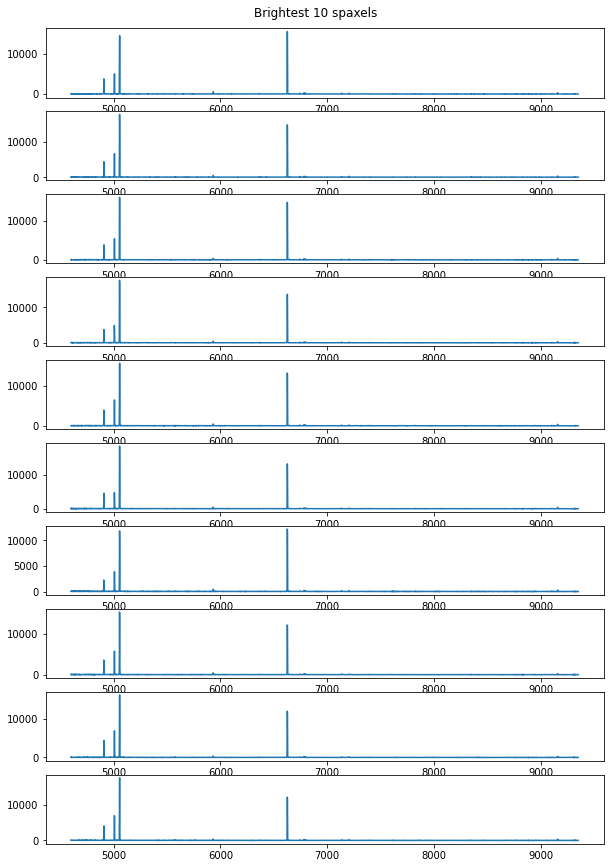

In [172]:
fig, axs = plt.subplots(10, figsize = (10, 15))
fig.suptitle('Brightest 10 spaxels', y=0.9)

axs[0].plot(wavelength, Flux75[:, b_pix[0]])
axs[1].plot(wavelength, Flux75[:, b_pix[1]])
axs[2].plot(wavelength, Flux75[:, b_pix[2]])
axs[3].plot(wavelength, Flux75[:, b_pix[3]])
axs[4].plot(wavelength, Flux75[:, b_pix[4]])
axs[5].plot(wavelength, Flux75[:, b_pix[5]])
axs[6].plot(wavelength, Flux75[:, b_pix[6]])
axs[7].plot(wavelength, Flux75[:, b_pix[7]])
axs[8].plot(wavelength, Flux75[:, b_pix[8]])
axs[9].plot(wavelength, Flux75[:, b_pix[9]])

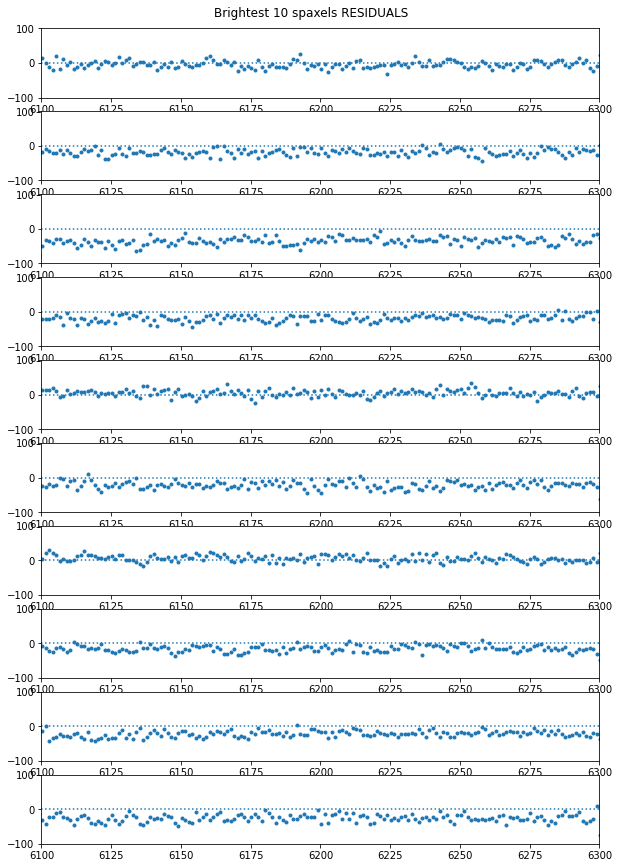

In [171]:
fig, axs = plt.subplots(10, figsize = (10, 15))
fig.suptitle('Brightest 10 spaxels RESIDUALS', y=0.9)

for i in range(10):
    residuals = Flux75[:, b_pix[i]] - model(wavelength, c0_75[b_pix[i]], c1_75[b_pix[i]],
                                        amplitudes75[b_pix[i]], mean75[b_pix[i]], stddev75[b_pix[i]])
    axs[i].axhline(0, 0, 1, linestyle = 'dotted')
    axs[i].scatter(wavelength, residuals, marker='.')
    axs[i].set_xlim(6100, 6300)
    axs[i].set_ylim(-100, 100)
    
